### Bitcoin Price Analysis
Source for data: https://min-api.cryptocompare.com/

In [18]:
# Import Libraries
import pandas as pd
import numpy as np
import urllib
import requests

# Chart libraries + settings
%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
pd.options.mode.chained_assignment = None  # default='warn' - disable some pandas warnings

In [19]:
# Load Bitcoin Prices into a dataframe
# Ticker is customizable
ticker = "BTC"
# Cryptocompare URL and fiels
base_url = 'https://min-api.cryptocompare.com/data/histoday'
ticker_field = 'fsym'
field_dict = {'tsym': 'USD','allData': 'true'}
# Convert the field dict into a url encoded string
url_args = "&" + urllib.parse.urlencode(field_dict)
ticker = ticker.upper()
globalURL = (base_url + "?" + ticker_field + "=" + ticker + url_args)


In [20]:
# Request the data
resp = requests.get(url=globalURL)
data = resp.json()
data["Response"]

'Success'

In [21]:
# Parse the JSON into a Pandas DataFrame
try:
    df = pd.DataFrame.from_dict(data['Data'])
    df = df.rename(columns={'time': 'date'})
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df.set_index('date', inplace=True)
    df_save = df[['close', 'open', 'high', 'low']]
except Exception as e:
    self.errors.append(e)
    df_save = None

In [22]:
# Include percentage change and other columns 
df = df_save
df['change'] = df['close'].pct_change()

In [23]:
# Show Log chart of data

<AxesSubplot:title={'center':'Historical Chart (BTC) - Log Y axis'}, xlabel='date'>

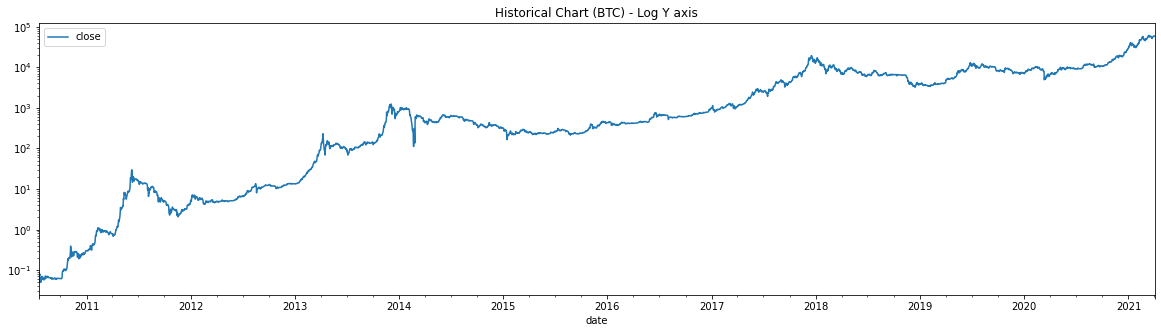

In [24]:
df[['close']].plot(kind='line', 
                   logy=True, 
                   figsize=(20,5), 
                   title='Historical Chart ('+ticker.upper()+') - Log Y axis')

In [39]:
def range_calc(days):
    # Check the range for this period between the intraday high and intraday low
    df['max_'+str(days)] = df['high'].rolling(days).max()
    df['min_'+str(days)] = df['low'].rolling(days).min()
    df['chg_'+str(days)] = (df['max_'+str(days)] / df['min_'+str(days)]) - 1

d = 10
range_calc(d)

In [40]:
# Latest % value for d days
last_chg = df['chg_'+str(d)][-1]
print ("Last Range = " + str(last_chg * 100) + "%")
print ("High = " +  str(df['max_'+str(d)][-1]))
print ("Low = " +  str(df['min_'+str(d)][-1]))
print ("Last = " +  str(df['close'][-1]))


Last Range = 19.154744713509086%
High = 60061.51
Low = 50406.31
Last = 58317.27


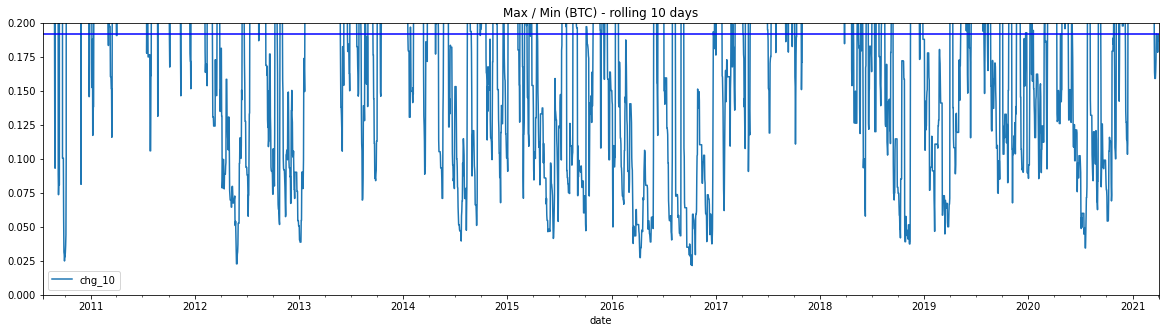

In [41]:
df[['chg_'+str(d)]].plot(
                    kind='line', 
                    figsize=(20,5), 
                    title='Max / Min ('+ticker.upper()+') - rolling '+str(d)+' days')

axes = plt.gca()
axes.set_ylim([0,0.2])
plt.axhline(df['chg_'+str(d)][-1], color="blue")
plt.show()

In [42]:
# Number of total days
total = df.count().close
total

3914

In [43]:
# How many where lower the current level?
df_lower = df.loc[df['chg_'+str(d)] < last_chg]
lower = df_lower.count().close
print ("Number of days where the range was lower = " + str(lower))
print ("Percentage of total = " + str(lower / total * 100) + "%")

Number of days where the range was lower = 1786
Percentage of total = 45.63106796116505%


In [44]:
# Filter the list for points that are in consecutive days
df_lower['n_days'] = df_lower.index
df_lower['diff'] = (df_lower['n_days'] - df_lower['n_days'].shift()).dt.days
df_lower = df_lower[df_lower['diff'] != 1]

<AxesSubplot:xlabel='date'>

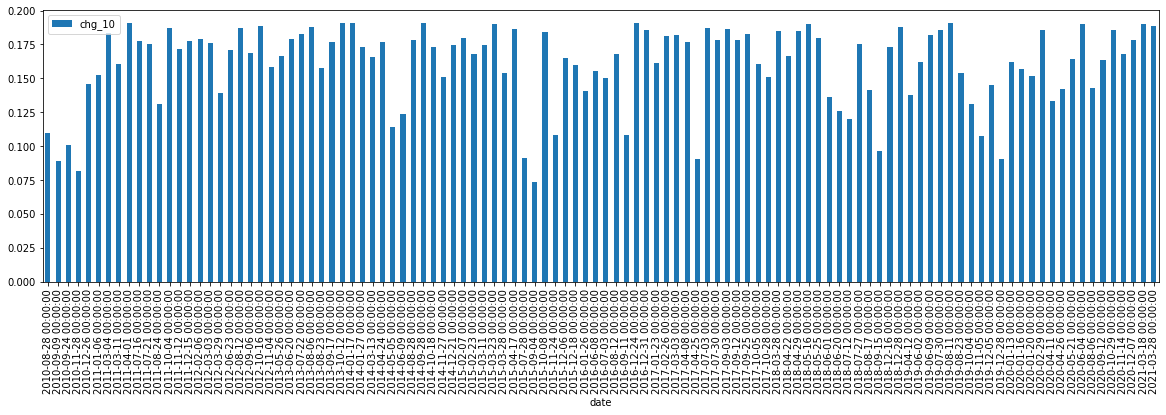

In [45]:
# Histogram of dates and returns
df_lower[['chg_'+str(d)]].plot(
                    kind='bar', 
                    figsize=(20,5))
                    

In [46]:
def find_price(date):
    try:
        price = df.loc[date]['close']
    except Exception as e:
        return None
    return (price)
    
days_list = [5, 10, 30, 90, 365]
cols = ['close']
for element in days_list:
    df_lower['date_after_' + str(element) + '_days'] = df_lower['n_days'] + pd.DateOffset(element)
    df_lower['price_after_' + str(element) + '_days'] = df_lower['date_after_' + str(element) + '_days'].apply(find_price)
    cols.append('price_after_' + str(element) + '_days')
    df_lower['return_after_' + str(element) + '_days'] = (df_lower['price_after_' + str(element) + '_days'] / df_lower['close']) - 1
    cols.append('return_after_' + str(element) + '_days')


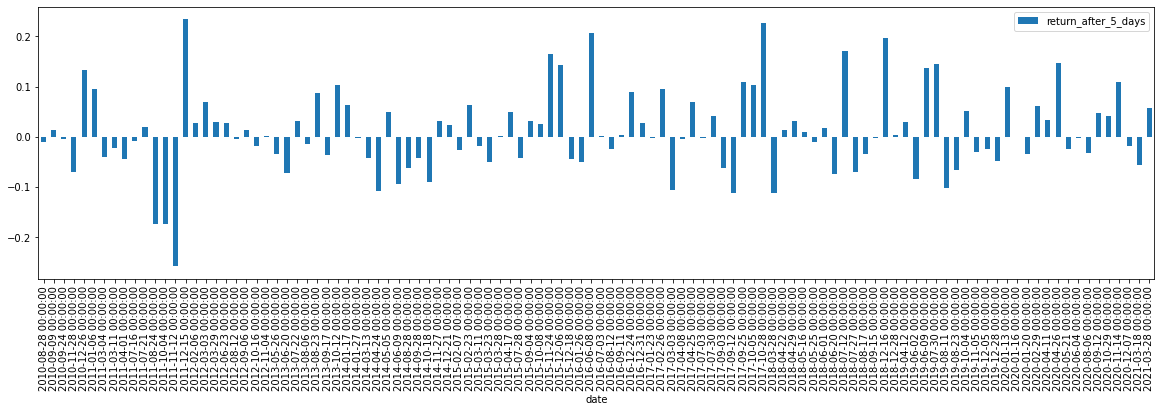

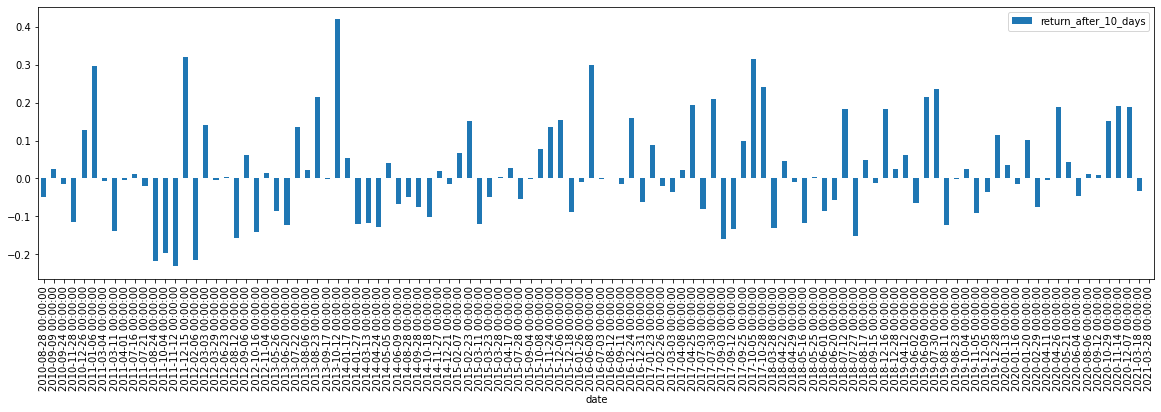

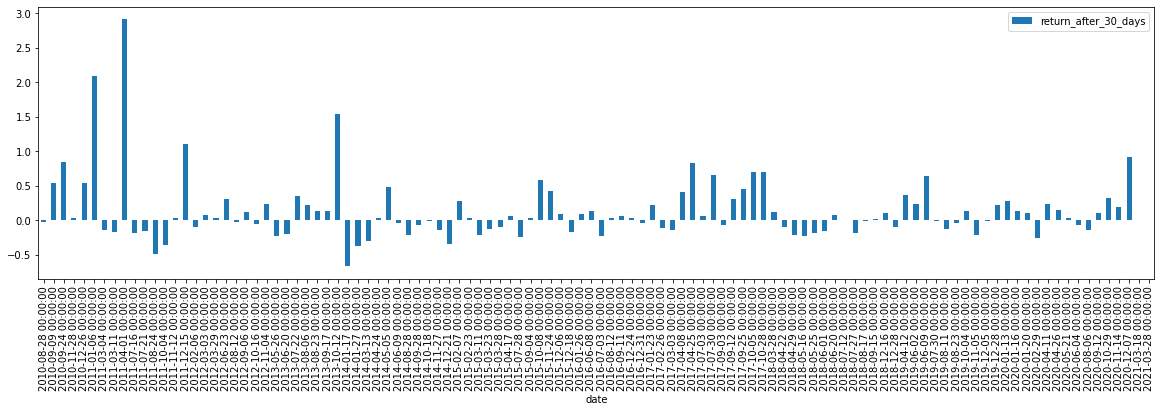

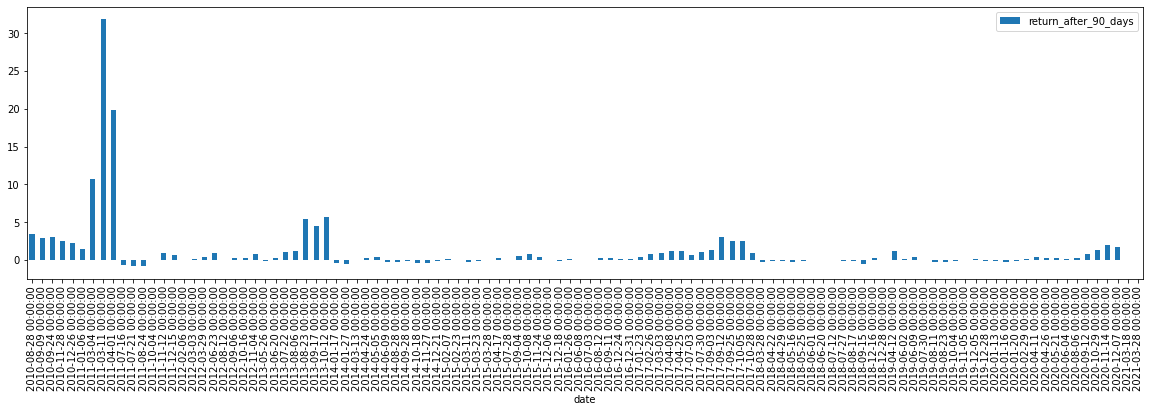

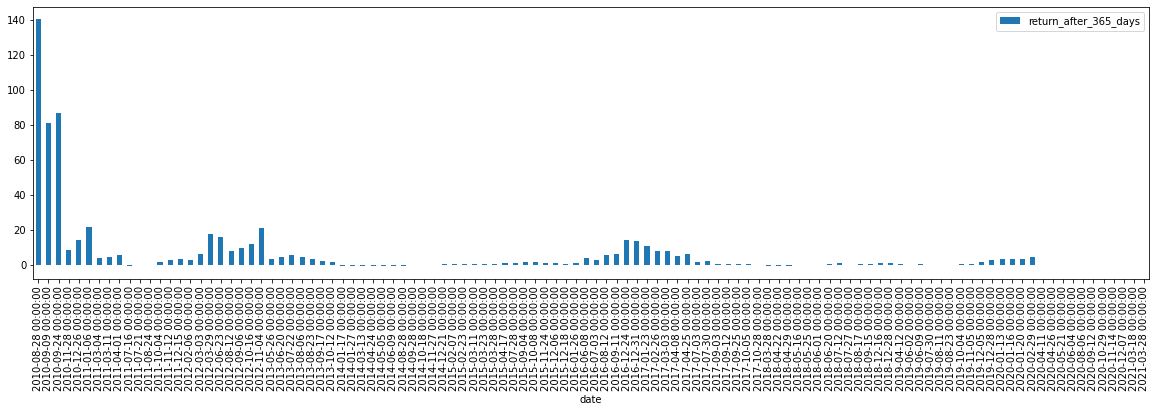

In [47]:
# Average results
for element in days_list:
    df_lower[['return_after_'+str(element)+'_days']].plot(
                    kind='bar', 
                    figsize=(20,5))


In [48]:
# Summary for each date range
for element in days_list:
    print ('-------------------------------------------------------------')
    print ('Returns on following ' + str(element) + ' days')
    print ('average return = ' + str(df_lower[['return_after_'+str(element)+'_days']].mean()[0] * 100) + '%')
    print ('min return = ' + str(df_lower[['return_after_'+str(element)+'_days']].min()[0] * 100) + '%')
    print ('max return = ' + str(df_lower[['return_after_'+str(element)+'_days']].max()[0] * 100) + '%')

-------------------------------------------------------------
Returns on following 5 days
average return = 1.008296261432252%
min return = -25.767073573078193%
max return = 23.4375%
-------------------------------------------------------------
Returns on following 10 days
average return = 1.7817874953459913%
min return = -23.160673045199598%
max return = 42.06032612499126%
-------------------------------------------------------------
Returns on following 30 days
average return = 13.635813927330595%
min return = -66.47132504249798%
max return = 291.8098436894458%
-------------------------------------------------------------
Returns on following 90 days
average return = 111.73597610145471%
min return = -83.32108743570905%
max return = 3186.3636363636365%
-------------------------------------------------------------
Returns on following 365 days
average return = 619.3855765302134%
min return = -77.67178133667352%
max return = 14049.765990639626%
